## RAG using Multi-Vector Retriever
Multi-Vector Retriever uses a simple, powerful idea for RAG: decouple documents, which we want to use for answer synthesis, from a reference, which we want to use for retriever. As a simple example, we can create a summary of a verbose document optimized to vector-based similarity search, but still pass the full document into the LLM to ensure no context is lost during answer synthesis. Here, we show that this approach useful beyond raw text, and can be applied generally to either tables or images to support RAG.

![RAG Architecture](./RAG_Architecture.png)

## Installing All Python Packages

In [1]:
! pip install langchain unstructured[all-docs] pydantic lxml langchain_openai langchain_community html5lib chromadb

## Loading All Python Packages

In [34]:
import os
import io
import json
import uuid
import types
import pprint
import base64
import textwrap
import pandas as pd
from PIL import Image
from typing import Any
from io import StringIO
from pprint import pprint
from tabulate import tabulate
from bs4 import BeautifulSoup
from pydantic import BaseModel
import matplotlib.pyplot as plt
from langchain_openai import ChatOpenAI
from langchain.storage import InMemoryStore
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings
from langchain_core.messages import HumanMessage
from langchain_community.vectorstores import Chroma
from unstructured.partition.pdf import partition_pdf
from langchain.retrievers.multi_vector import MultiVectorRetriever

## Data Loading

### Partition PDF and extract tables, text, and images

In [3]:
hi_res_model_name = "yolox"

In [4]:
os.environ["EXTRACT_IMAGE_BLOCK_CROP_HORIZONTAL_PAD"] = "150"
os.environ["EXTRACT_IMAGE_BLOCK_CROP_VERTICAL_PAD"] = "150"

In [5]:
current_folder_path = os.getcwd() + "/"
pdf_file_name = "TSLA-Q3-2023-Update-3.pdf"
image_tables_path = os.path.join(current_folder_path, pdf_file_name.split(".pdf")[0]+"_"+hi_res_model_name+"_150") + "/"
if not os.path.exists(image_tables_path):
    os.mkdir(image_tables_path)

In [6]:
raw_pdf_elements = partition_pdf(
    filename=current_folder_path + pdf_file_name,
    strategy="hi_res",
    hi_res_model_name=hi_res_model_name,
    extract_images_in_pdf=True,
    infer_table_structure=True,
    extract_image_block_types=["Image", "Table"],
    chunking_strategy="by_title",
    max_characters=4000,
    new_after_n_chars=3800,
    combine_text_under_n_chars=2000,
    extract_image_block_to_payload=False,
    extract_image_block_output_dir=image_tables_path
)

Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
len(os.listdir(image_tables_path))

23

In [8]:
os.listdir(image_tables_path)

['table-23-8.jpg',
 'figure-9-32.jpg',
 'figure-16-67.jpg',
 'figure-17-75.jpg',
 'table-22-7.jpg',
 'table-6-3.jpg',
 'figure-12-46.jpg',
 'figure-8-26.jpg',
 'table-21-6.jpg',
 'figure-8-27.jpg',
 'table-7-4.jpg',
 'table-20-5.jpg',
 'figure-18-81.jpg',
 'table-2-1.jpg',
 'figure-16-68.jpg',
 'figure-17-74.jpg',
 'figure-18-80.jpg',
 'figure-16-66.jpg',
 'table-24-9.jpg',
 'figure-9-33.jpg',
 'figure-17-73.jpg',
 'figure-7-21.jpg',
 'table-4-2.jpg']

### Categorizing Different Elements Extracted From PDF File

In [9]:
category_counts = {}
for element in raw_pdf_elements:
    category = str(type(element))
    if category in category_counts:
        category_counts[category] += 1
    else:
        category_counts[category] = 1
unique_categories = set(category_counts.keys())
category_counts

{"<class 'unstructured.documents.elements.CompositeElement'>": 16,
 "<class 'unstructured.documents.elements.Table'>": 7,
 "<class 'unstructured.documents.elements.TableChunk'>": 4}

### Seperating Text, Table and Image Elements

In [10]:
class Element(BaseModel):
    type: str
    text: Any
    
categorized_elements = []
for element in raw_pdf_elements:
    if "unstructured.documents.elements.Table" in str(type(element)):
        categorized_elements.append(Element(type="table", text=str(element)))
    elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
        categorized_elements.append(Element(type="text", text=str(element)))

# Text
text_elements = [e for e in categorized_elements if e.type == "text"]
print(len(text_elements))

# Tables
table_elements = [e for e in categorized_elements if e.type == "table"]
print(len(table_elements))

# Images
image_files = [os.path.join(image_tables_path, f) for f in os.listdir(image_tables_path) if f.endswith(('png', 'jpg', 'jpeg'))]
print(len(image_files))

16
11
23


In [11]:
new_table_elements = []
for element in raw_pdf_elements:
    if "unstructured.documents.elements.Table" in str(type(element)):
        element_dict = element.to_dict() 
        new_table_elements.append(element_dict['metadata']['text_as_html'])

### Printing & Saving the Tables Extracted From PDF

In [12]:
c = 1
for element in raw_pdf_elements:
    if "unstructured.documents.elements.Table" in str(type(element)):
        element_dict = element.to_dict() 
        print("_____________________________________________________________________")
        print(f"TABLE {c}")
        #print(element_dict['metadata']['text_as_html'])
        try:
            df_tables = pd.read_html(StringIO(element_dict['metadata']['text_as_html']))
            for i, df_table in enumerate(df_tables):
                print(df_table)
                file_name = f"Table{c}_{i+1}.xlsx"
                with pd.ExcelWriter(file_name, engine='xlsxwriter') as excel_writer:
                    df_table.to_excel(excel_writer, sheet_name=f"Table{c}_{i}", index=False)
        except ValueError as e:
            print(f"Error reading HTML table: {e}")
        print("_____________________________________________________________________")
        c += 1

_____________________________________________________________________
TABLE 1
                      0
0     Financial Summary
1   Operational Summary
2      Vehicle Capacity
3       Core Technology
4               Outlook
5       Photos & Charts
6           Key Metrics
7  Financial Statements
_____________________________________________________________________
_____________________________________________________________________
TABLE 2
                                                    0        1        2  \
0                            otal automotive revenues    18692    21307   
1               ‘nergy generation and storage revenue     1117     1310   
2                           ervices and other revenue     1645     1701   
3                                       otal revenues    21454    24318   
4                                   otal gross profit     5382     5777   
5                              otal GAAP gross margin    25.1%    23.8%   
6                                

### Viewing the Images Extracted From PDF

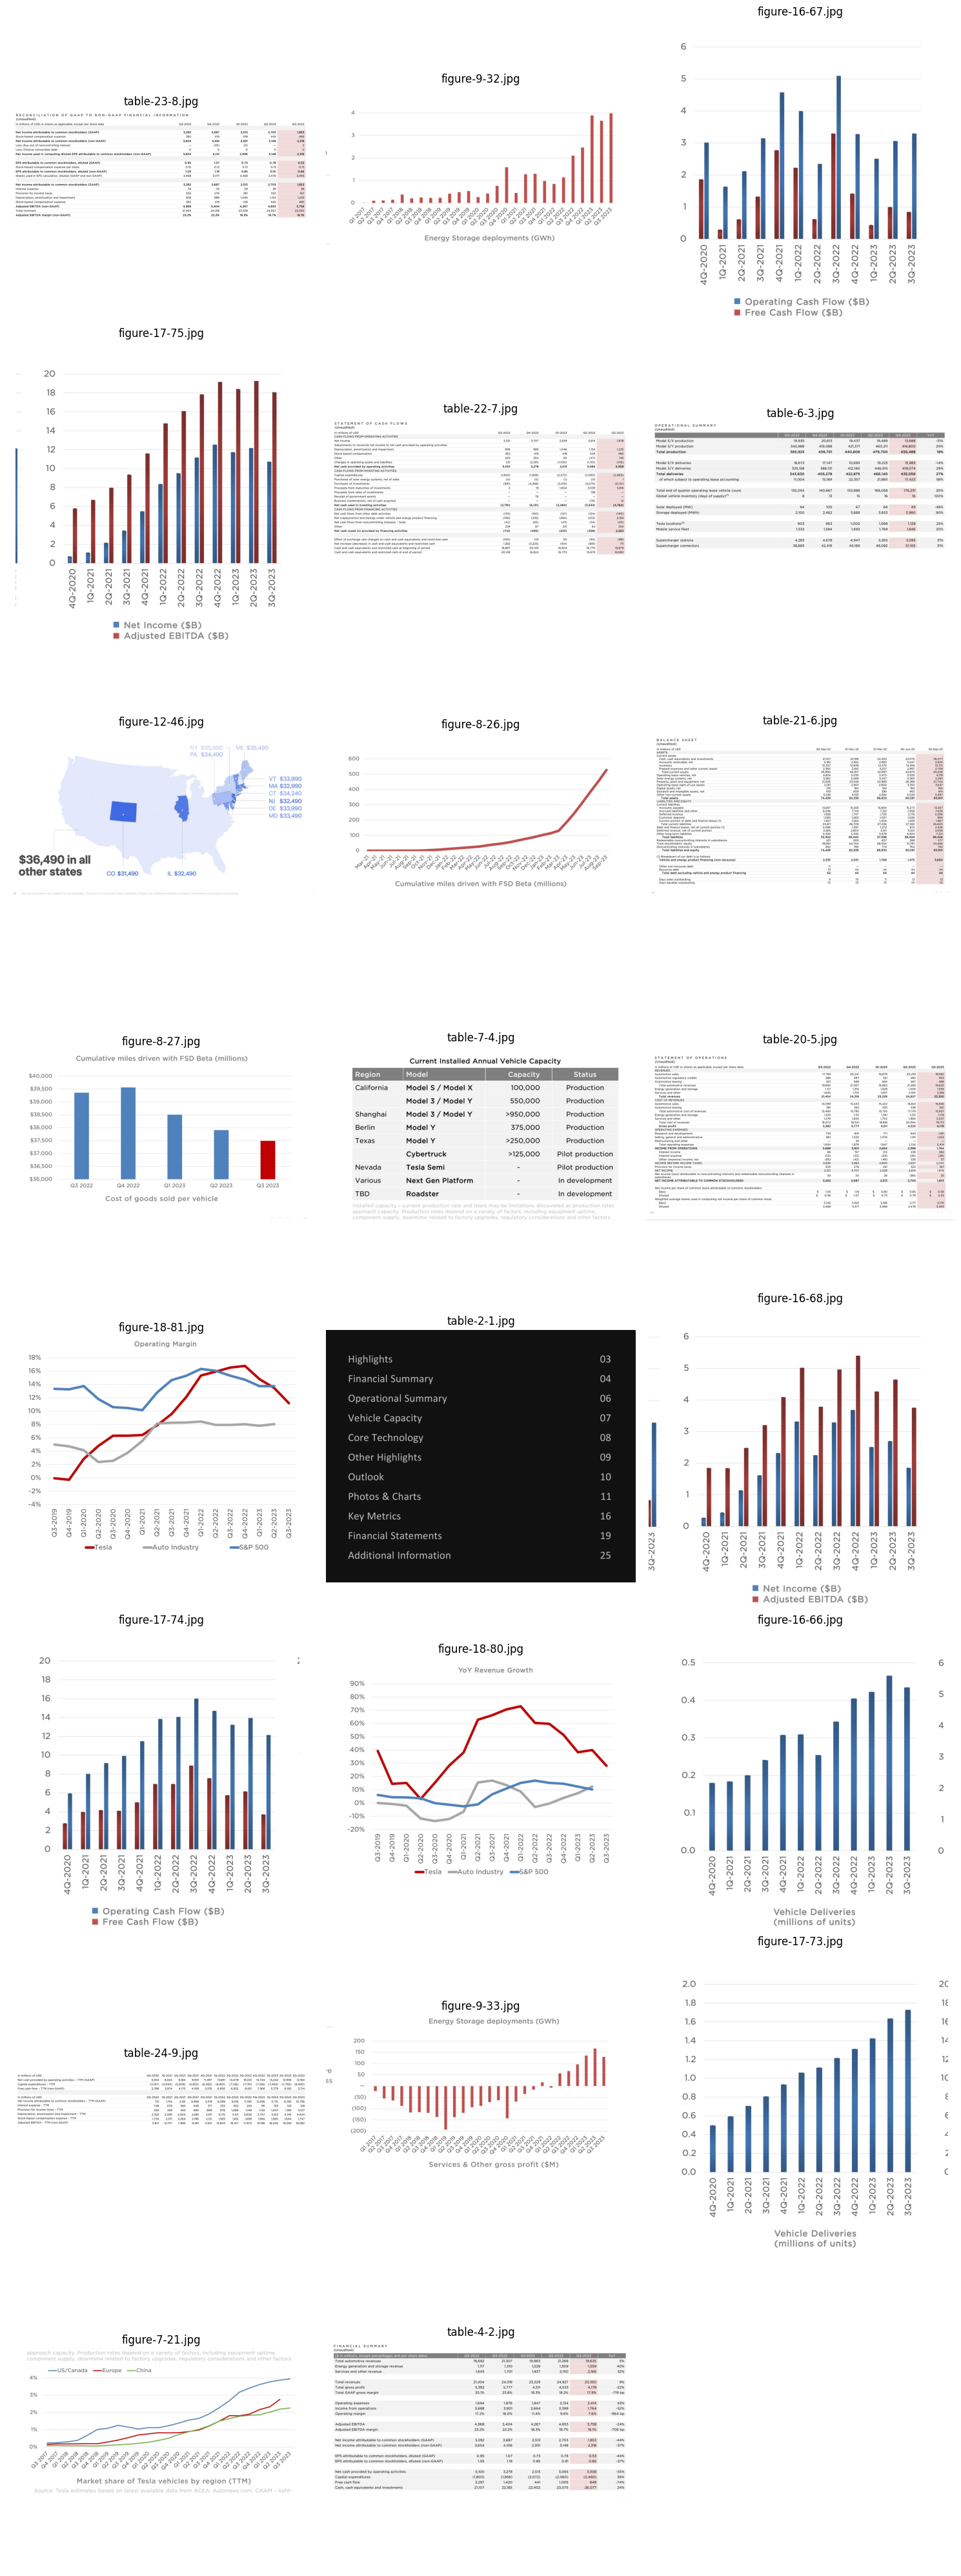

In [13]:
def view_images(image_files):
    num_columns = 3
    num_rows = (len(image_files) + num_columns - 1) // num_columns
    fig, axs = plt.subplots(num_rows, num_columns, figsize=(15, 5*num_rows))
    axs = axs.flatten()

    for ax in axs:
        ax.axis('off') 

    for i, image_file in enumerate(image_files):
        img = Image.open(image_file)
        axs[i].imshow(img)
        axs[i].set_title(os.path.basename(image_file))

    plt.tight_layout()
    plt.show()
view_images(image_files)

In [37]:
#table_images = [image_file for image_file in image_files if "table" in image_file.lower()]
#table_images

In [38]:
#non_table_image_files = [image_file for image_file in image_files if "table" not in image_file.lower()]
#non_table_image_files

## Multi-vector retriever

Generating Summaries to retrieve Raw Text, Tables and Images.

### Text and Table summaries

In [14]:
llm = ChatOpenAI(model="gpt-4o")

In [15]:
def summarize_text(text):
    response = llm.invoke(
        [
            HumanMessage(
                content=[
                    {"type": "text", "text": """You are an assistant tasked with summarizing text of the provided text chunk. \
                                                These summaries will be embedded and used to retrieve the raw text chunk. \
                                                Give a detailed summary of the provided text chunk that is well optimized for retrieval. \
                                                If there is no text present, then just return "No text" """},
                    {"type": "text", "text": text}
                ]
            )
        ]
    )
    return response.content


def summarize_table(table):
    response = llm.invoke(
        [
            HumanMessage(
                content=[
                    {"type": "text", "text": """You are an assistant tasked with summarizing tables which is given below to you in the form of a html string. Parse this html string to interpret/understand the table and than generate a detailed summary. \
                    Also make sure you include the table name in the summary, provided the html string has table name. \
                    These summaries will be embedded and used to retrieve the raw tables. \
                    If the provided html string contains tables, then give a detailed summary of the table that is well optimized for retrieval. If there is no table present, then just return "No table"."""},
                    {"type": "text", "text": table}
                ]
            )
        ]
    )
    return response.content

def load_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')


def summarize_image(image_path):
    image_base64 = load_image(image_path)
    response = llm.invoke(
        [
            HumanMessage(
                content=[
                    {"type": "text", "text": """You are an assistant tasked with summarizing images for retrieval. \
                                                The images contain graphs or tables. \
                                                If the graph or table in the image has a name i.e a graph name or table name, than add that to the summary as well. \
                                                These summaries will be embedded and used to retrieve the raw image. \
                                                Give a detailed summary of the image that is well optimized for retrieval. \
                                                If there is no content in the image, then just return "No image"."""},
                    {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{image_base64}"}}
                ]
            )
        ]
    )
    return response.content

In [16]:
# Summarize Text
text_summaries = [summarize_text(text.text) for text in text_elements]

In [17]:
# Summarize Tables
table_summaries = [summarize_table(table) for table in new_table_elements]

In [18]:
# Summarize images
image_summaries = [summarize_image(image_file) for image_file in image_files]

### Add to vectorstore

Using Multi Vector Retriever to store Raw Text, Tables & Images alogn with their summaries.

In [19]:
# Initialize vectorstore and docstore
vectorstore = Chroma(collection_name="tesla_fin_doc", embedding_function=OpenAIEmbeddings())
store = InMemoryStore()
id_key = "doccs_id"

retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
)

# Store text summaries
text_ids = [str(uuid.uuid4()) for _ in text_elements]
summary_texts = [
    Document(page_content=s, metadata={id_key: text_ids[i]})
    for i, s in enumerate(text_summaries)
]
retriever.vectorstore.add_documents(summary_texts)
retriever.docstore.mset(list(zip(text_ids, [text.text for text in text_elements])))

# Debugging: Verify text storage
#print("Stored Texts:", retriever.docstore.mget(text_ids)[:2])

# Store table summaries
table_ids = [str(uuid.uuid4()) for _ in new_table_elements]
summary_tables = [
    Document(page_content=s, metadata={id_key: table_ids[i]})
    for i, s in enumerate(table_summaries)
]
retriever.vectorstore.add_documents(summary_tables)
retriever.docstore.mset(list(zip(table_ids, [table for table in new_table_elements])))

# Debugging: Verify table storage
#print("Stored Tables:", retriever.docstore.mget(table_ids)[:2])

# Store image summaries
image_ids = [str(uuid.uuid4()) for _ in image_files]
summary_images = [
    Document(page_content=s, metadata={id_key: image_ids[i]})
    for i, s in enumerate(image_summaries)
]
retriever.vectorstore.add_documents(summary_images)
retriever.docstore.mset(list(zip(image_ids, [f"data:image/jpeg;base64,{load_image(image_file)}" for image_file in image_files])))

# Debugging: Verify image storage
#print("Stored Images:", retriever.docstore.mget(image_ids)[:2])

## RAG

Running the RAG pipeline

In [35]:
def pretty_print(data):
    if isinstance(data, str):
        wrapped_text = textwrap.fill(data, width=7150)
        print(wrapped_text)
    elif isinstance(data, (list, dict)):
        pprint.pprint(data, width=70, compact=True)
    elif isinstance(data, pd.DataFrame):
        print(tabulate(data, headers='keys', tablefmt='psql'))
    else:
        print(data)

In [20]:
def display_table(html_string):
    soup = BeautifulSoup(html_string, 'html.parser')
    rows = soup.find_all('tr')
    table_data = []
    for row in rows:
        cols = row.find_all('td')
        cols = [ele.text.strip() for ele in cols]
        table_data.append(cols)
    df = pd.DataFrame(table_data)
    print(df)

In [21]:
def display_base64_image(encoded_image):
    base64_string = encoded_image.split("base64,")[1]
    image_data = base64.b64decode(base64_string)
    image = Image.open(io.BytesIO(image_data))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [39]:
def rag_pipeline(query,verbose=False):
    raw_docs = retriever.invoke(query)
    context = []
    context.append({"type":"text", "text":"""Only based on the information given in this prompt, answer the question: {0}. Only use the information from the prompt, which seems best for answering the query. If the information given in the context is redundant than kindly ignore that piece of information. If you are unable to answer the query based on the information given in the prompt than just return "No information found. Kindly provide more context to the question." """.format(query)})
    if verbose:
        print("Raw Documents Retrieved from Vector DB")
    for i,doc in enumerate(raw_docs):
        if verbose:
            print("------------------------------------------------------------------------------------------------------------------------------")
            print("\n")
        if "data:image/jpeg;base64," in doc:
            context.append({"type": "image_url", "image_url": {"url": doc}})
            if verbose:
                print("DOC {0} ---> IMAGE RETRIEVED --->".format(i+1))
                display_base64_image(doc)
        else:
            context.append({"type": "text", "text": doc})
            if verbose:
                print("DOC {0} ---> TEXT/TABLE RETRIEVED --->".format(i+1))
                if "<td>" in doc or "<tr>" in doc:
                    display_table(doc)
                else:
                    print(doc)
        if verbose:
            print("\n")
    output = llm.invoke([HumanMessage(content=context)])
    return output.content

In [48]:
query = "explain the YoY revenue growth graph"
output = rag_pipeline(query)
pretty_print(output)

The YoY Revenue Growth graph compares the year-over-year revenue growth trends of Tesla, the Auto Industry, and the S&P 500 from Q3 2019 to Q3 2023.   - **Tesla** (red line): Tesla's revenue growth shows significant fluctuations. It experienced a peak growth rate of around 70% in Q2 2021 but has been declining since then, reaching around 20% in Q3 2023.    - **Auto Industry** (gray line): The auto industry's revenue growth has been relatively stable but lower compared to Tesla. It briefly dipped into negative growth in Q2 2020 but recovered and has maintained a growth rate around 10% in recent quarters.  - **S&P 500** (blue line): The S&P 500's revenue growth has been the most stable among the three, consistently hovering around 10%.  Overall, the graph highlights Tesla's more volatile and higher revenue growth compared to the broader auto industry and the S&P 500, which have shown more stable growth patterns.


In [56]:
query = "What are the trends in vehicle deliveries"
output = rag_pipeline(query)
pretty_print(output)

Based on the provided charts, the trend in vehicle deliveries shows a consistent increase over time. Both charts illustrate a general upward trajectory in the number of vehicle deliveries from 4Q-2020 to 3Q-2023. This indicates a steady growth in vehicle deliveries over this period.


In [50]:
query = "What is the annual vehicle capacity for different models in california?"
output = rag_pipeline(query)
pretty_print(output)

The annual vehicle capacity for different models in California is as follows:  - **Model S / Model X**: 100,000 - **Model 3 / Model Y**: 550,000


In [51]:
query = "What is the cost of goods sold per vehicle from 2022 to 2023?"
output = rag_pipeline(query)
pretty_print(output)

Based on the information provided in the prompt, the cost of goods sold per vehicle from 2022 to 2023 is as follows:  - Q3 2022: ~$39,000 - Q4 2022: ~$39,000 - Q1 2023: ~$38,000 - Q2 2023: ~$37,000 - Q3 2023: ~$37,000


In [58]:
query = "what are the operating expenses from 2022 to 2024?"
output = rag_pipeline(query)
pretty_print(output)

Based on the information provided in the prompt, the operating expenses for the given quarters are as follows:  - Q3-2022: 1,694 million USD - Q4-2022: 1,876 million USD - Q1-2023: 1,847 million USD - Q2-2023: 2,134 million USD - Q3-2023: 2,414 million USD  No information is provided for the operating expenses in the year 2024.


In [59]:
query = "What is the YoY for income from operations in the Financial Summary Table?"
output = rag_pipeline(query)
pretty_print(output)

The YoY (Year-over-Year) for income from operations in the Financial Summary Table is -52%.


In [54]:
query = "What is the total automotive revenue in Q3-2023"
output = rag_pipeline(query)
pretty_print(output)

The total automotive revenue in Q3-2023 is $19,625 million.


In [55]:
query = "what is the total revenue in statement of operations table for different quarters from 2022 to 2023"
output = rag_pipeline(query)
pretty_print(output)

The total revenue in the statement of operations table for different quarters from 2022 to 2023 is as follows:  - Q3-2022: $21,454 million - Q4-2022: $24,318 million - Q1-2023: $23,329 million - Q2-2023: $24,927 million - Q3-2023: $23,350 million
